<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CatsDogsFastAIMulticlass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs Multiclass Classification

# Setup

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# Filter out a 1.3 torch warning & imagebunchdata
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# Data

In [0]:
batch_size = 32

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_17.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_70.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_199.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_125.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_140.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, 
                                  fnames, pat, 
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  bs=batch_size).normalize(imagenet_stats)

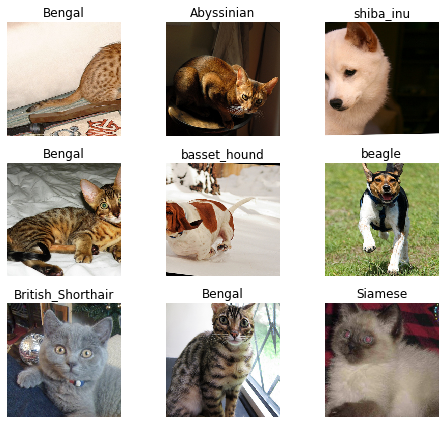

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# Resnet 34

## Model & Learning

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.999226,0.388216,0.122463,01:48
1,0.613833,0.288917,0.096752,01:47
2,0.425945,0.222443,0.077131,01:49
3,0.304781,0.216013,0.069689,01:49


In [0]:
learn.save('stage-1')

## Results

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

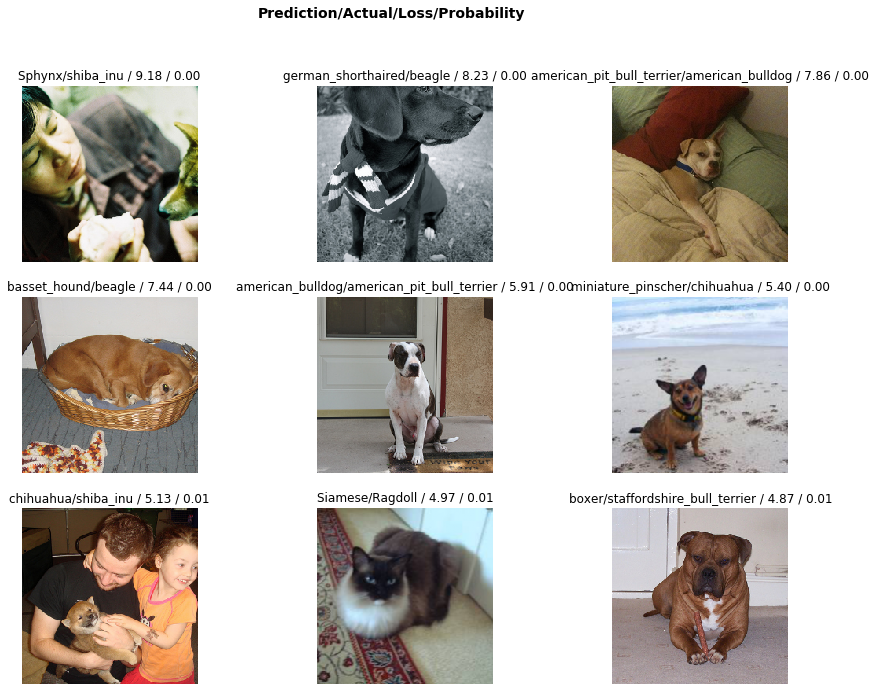

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

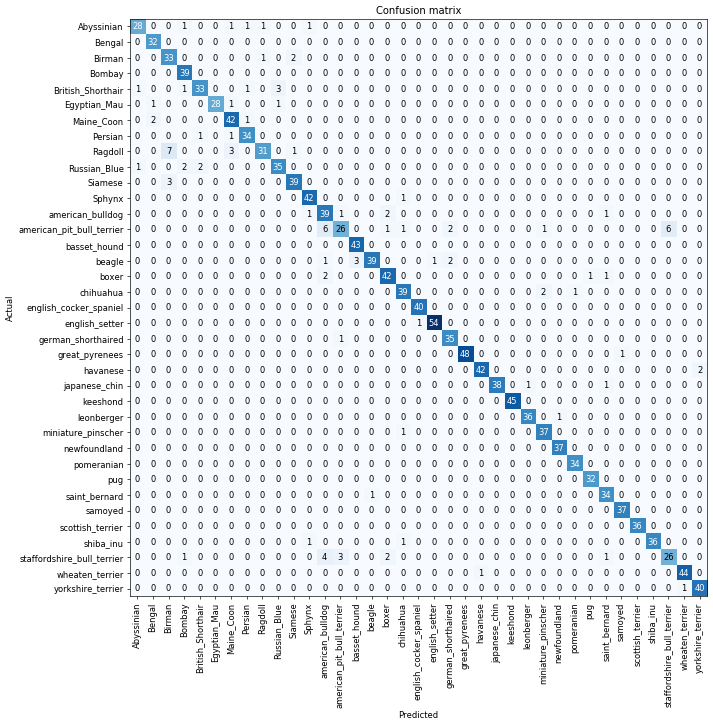

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Ragdoll', 'Maine_Coon', 3),
 ('Siamese', 'Birman', 3),
 ('beagle', 'basset_hound', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Birman', 'Siamese', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'german_shorthaired', 2),
 ('beagle', 'german_shorthaired', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('staffordshire_bull_terrier', 'boxer', 2)]

## Unfreeze, Fine Tune, Learning Rate

In [0]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.831776,0.387847,0.126522,01:54


In [0]:
learn.load('stage-1');

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


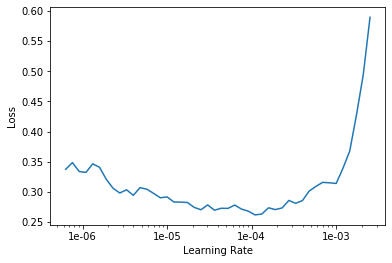

In [49]:
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.285471,0.205175,0.069012,01:59
1,0.233293,0.198766,0.064276,02:03


# Resnet 50

## Model & Learning

In [0]:
data = ImageDataBunch.from_name_re(path_img, 
                                   fnames, 
                                   pat, 
                                   ds_tfms=get_transforms(),
                                   size=299, 
                                   bs=batch_size // 2).normalize(imagenet_stats)

In [52]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


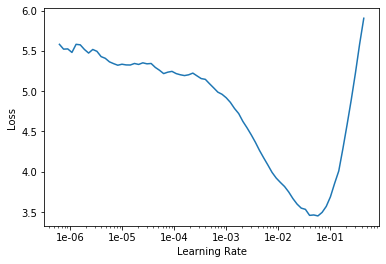

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.780886,0.336739,0.106901,03:39
1,0.670116,0.346133,0.100135,03:32
2,0.580453,0.292689,0.094046,03:33
3,0.421680,0.277878,0.072395,03:35
4,0.305484,0.207593,0.058863,03:34
5,0.225752,0.195560,0.056157,03:35
6,0.174998,0.171305,0.050744,03:34
7,0.163556,0.169475,0.047361,03:33


In [0]:
learn.save('stage-1-50')

## Unfreeze, Fine Tune, Learning Rate

In [56]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.170750,0.170870,0.052097,04:45
1,0.132349,0.174278,0.049391,04:41
2,0.124320,0.159784,0.046685,04:40


In [0]:
learn.load('stage-1-50');

## Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [59]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Ragdoll', 'Birman', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('samoyed', 'great_pyrenees', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('beagle', 'basset_hound', 2),
 ('keeshond', 'leonberger', 2),
 ('pomeranian', 'shiba_inu', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

# Predict
* Uploaded a couple dog photos for test
* They'll be erased when we release the compute

In [36]:
!ls /content/test_data/*

/content/test_data/IMG_1539.JPG


## Coco

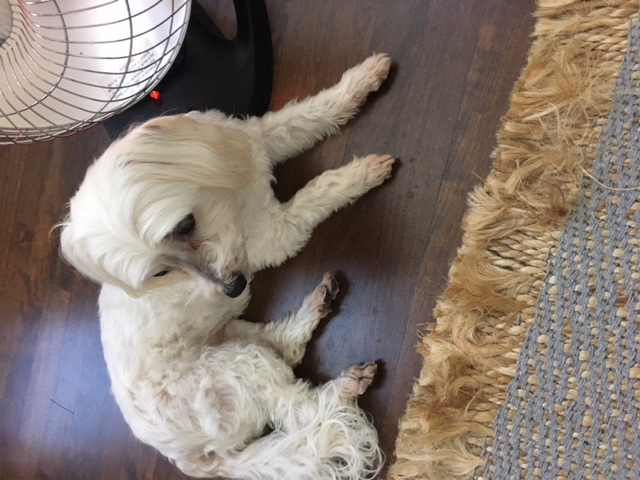

In [38]:
img = open_image("/content/test_data/IMG_1539.JPG")
img

In [39]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category havanese

## Pebbles

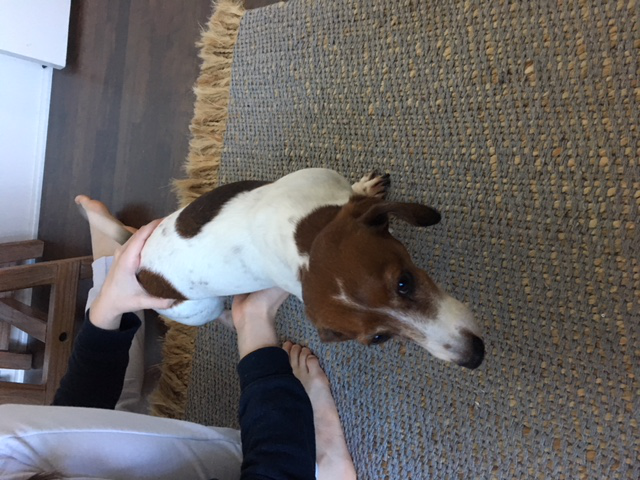

In [43]:
img = open_image("/content/test_data/IMG_1540.JPG")
img

In [44]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category beagle